**4장 – 모델 훈련**

_이 노트북은 4장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/04_training_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 설정

이 프로젝트에는 파이썬 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

또한 사이킷런 ≥ 1.0.1이 필요합니다:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

이전 챕터에서 했던 것처럼 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

그리고 `images/training_linear_models` 폴더(아직 존재하지 않는 경우)를 만들고, 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 선형 회귀

## 정규 방정식

In [5]:
import numpy as np

np.random.seed(42)  # 코드 예제를 재현 가능하게 만들기 위해
m = 100  # 샘플 개수
X = 2 * np.random.rand(m, 1)  # 열 벡터
y = 4 + 3 * X + np.random.randn(m, 1)  # 열 벡터

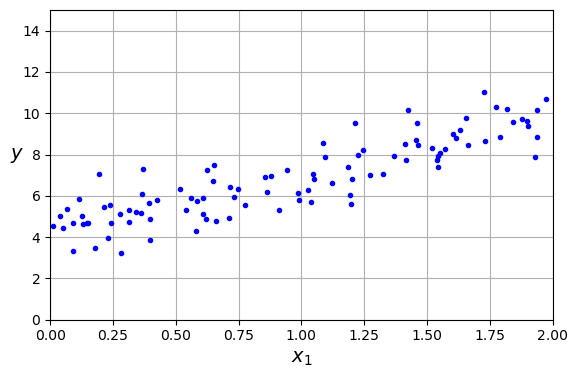

In [6]:
# 추가 코드 - 그림 4-1 생성 및 저장

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("generated_data_plot")
plt.show()

In [7]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # 각 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [8]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [9]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # 각 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

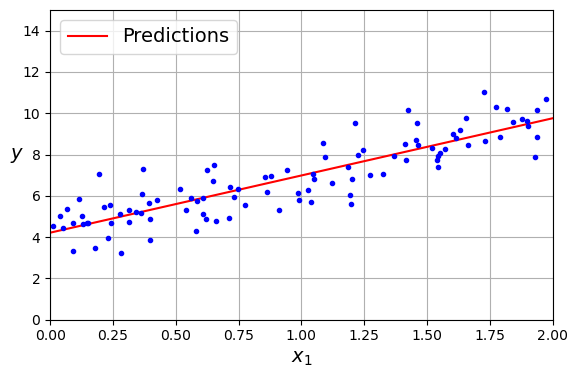

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # 추가 코드
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

# 추가 코드 - 그림 4-2를 꾸미고 저장합니다.
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")
save_fig("linear_model_predictions_plot")

plt.show()

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [12]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`LinearRegression` 클래스는 `scipy.linalg.lstsq()` 함수("least squares"의 약자)를 사용하므로 이 함수를 직접 사용할 수 있습니다:

In [13]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

이 함수는 $\mathbf{X}^+\mathbf{y}$을 계산합니다. $\mathbf{X}^{+}$는 $\mathbf{X}$의 _유사역행렬_ (pseudoinverse)입니다(Moore–Penrose 유사역행렬입니다). `np.linalg.pinv()`을 사용해서 유사역행렬을 직접 계산할 수 있습니다:

In [14]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

# 경사 하강법
## 배치 경사 하강법

In [15]:
eta = 0.1  # 학습률
n_epochs = 1000
m = len(X_b)  # 샘플 개수

np.random.seed(42)
theta = np.random.randn(2, 1)  # 모델 파라미터를 랜덤하게 초기화합니다

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

학습된 모델 파라미터:

In [16]:
theta

array([[4.21509616],
       [2.77011339]])

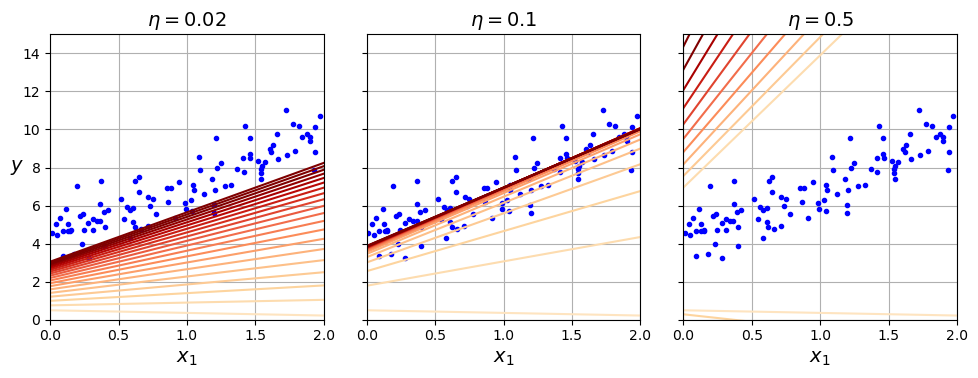

In [17]:
# 추가 코드 - 그림 4-8을 생성하고 저장합니다.

import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # 랜덤 초기화

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
save_fig("gradient_descent_plot")
plt.show()

## 확률적 경사 하강법

In [18]:
theta_path_sgd = []  # 추가 코드 - 다음 그림을 그리기 위해 매개변수 공간에서 theta의 경로를 저장합니다.

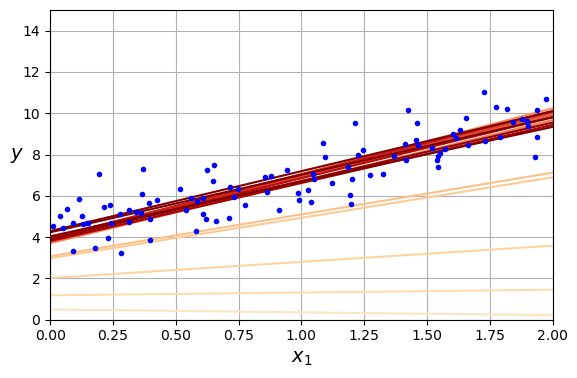

In [19]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # 랜덤 초기화

n_shown = 20  # 추가 코드 - 아래 그림을 생성하는 데만 필요합니다.
plt.figure(figsize=(6, 4))  # 추가 코드

for epoch in range(n_epochs):
    for iteration in range(m):

        # 추가 코드 - 이 네 라인은 그림을 생성하는 데 사용됩니다.
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # SGD의 경우 m으로 나누지 않습니다
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # 추가 코드 - 그림을 생성하기 위해

# 추가 코드 - 이 섹션은 그림 4-10을 꾸미고 저장합니다.
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("sgd_plot")
plt.show()

In [20]:
theta

array([[4.21076011],
       [2.74856079]])

In [21]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # fit()이 1D 타깃을 기대하기 때문에 y.ravel()로 씁니다

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

## 미니배치 경사 하강법

이 섹션의 코드는 다음 그림을 생성하는 데 사용되며 책에는 나와 있지 않습니다.

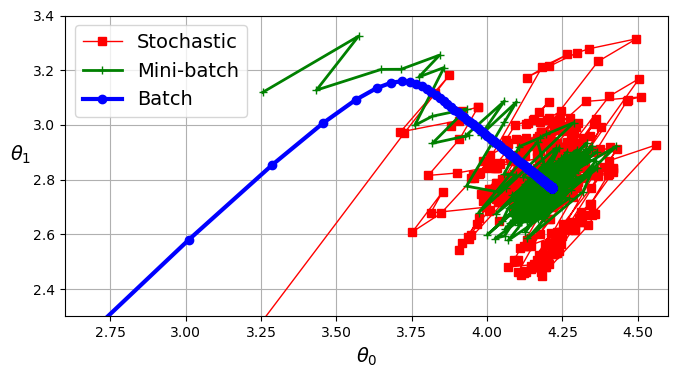

In [23]:
# 추가 코드 - 이 셀은 그림 4-11을 생성하고 저장합니다.

from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)  # 랜덤 초기화

t0, t1 = 200, 1000  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid()
save_fig("gradient_descent_paths_plot")
plt.show()

# 다항 회귀

In [24]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

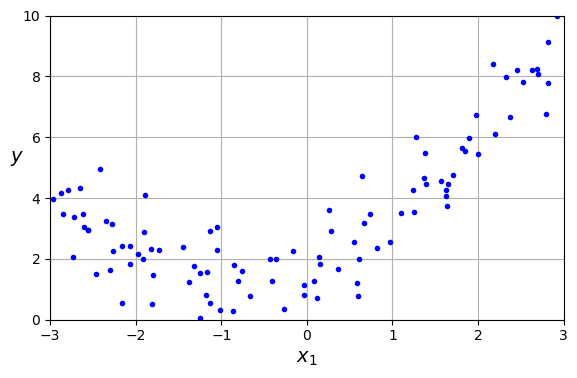

In [25]:
# 추가 코드 - 이 셀은 그림 4-12를 생성하고 저장합니다.
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_data_plot")
plt.show()

In [26]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [27]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

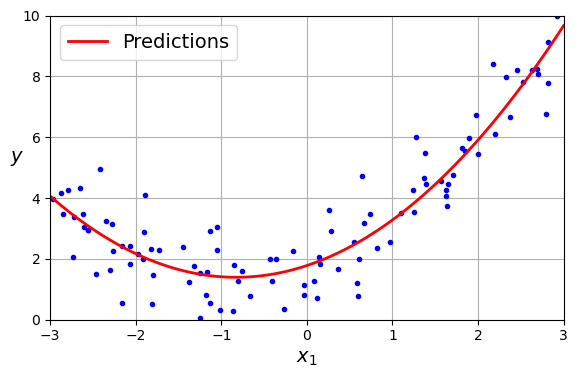

In [29]:
# 추가 코드 - 이 셀은 그림 4-13을 생성하고 저장합니다.

X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_predictions_plot")
plt.show()

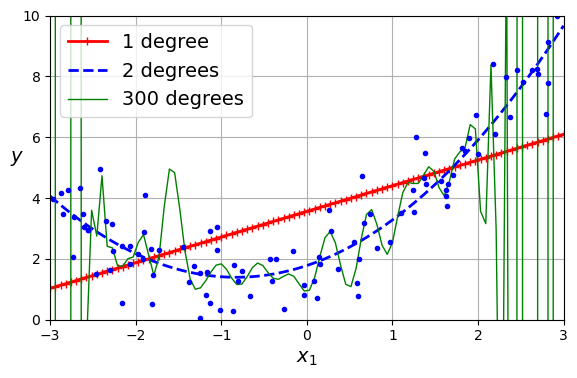

In [30]:
# extra code – this cell generates and saves Figure 4–14

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("high_degree_polynomials_plot")
plt.show()

# 학습 곡선

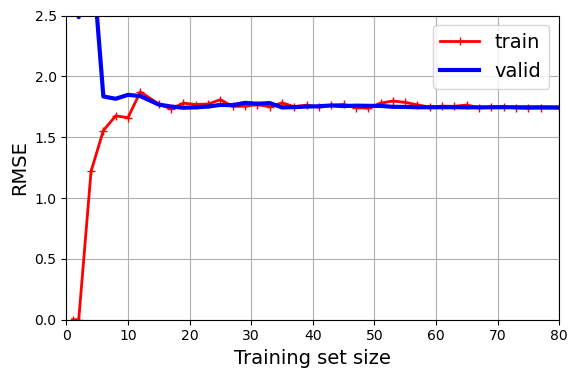

In [31]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # 추가 코드
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# 추가 코드 - 그림 4-15를 꾸미고 저장합니다.
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
save_fig("underfitting_learning_curves_plot")

plt.show()

In [32]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

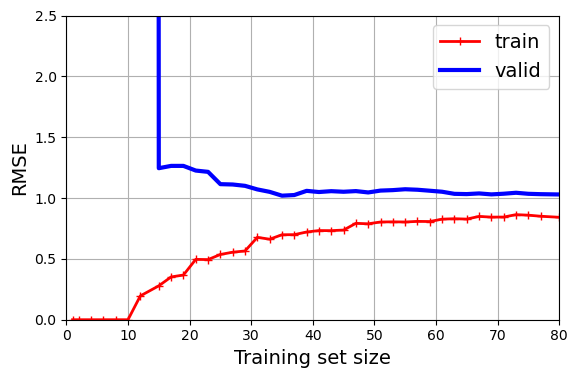

In [33]:
# 추가 코드 - 그림 4-16을 생성하고 저장합니다.

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
save_fig("learning_curves_plot")
plt.show()

# 규제가 있는 선형 모델

## 릿지 회귀

매우 작고 잡음이 많은 선형 데이터셋을 생성해 보겠습니다:

In [34]:
# 추가 코드 - 이전에도 이러한 유형의 생성을 여러 번 수행한 적이 있습니다.
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

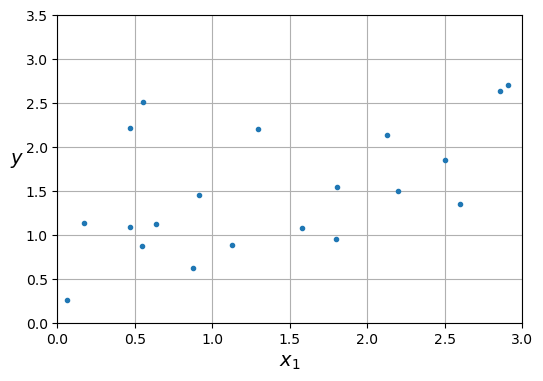

In [35]:
# 추가 코드 - 방금 생성한 데이터셋을 간단히 살펴보기
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [36]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

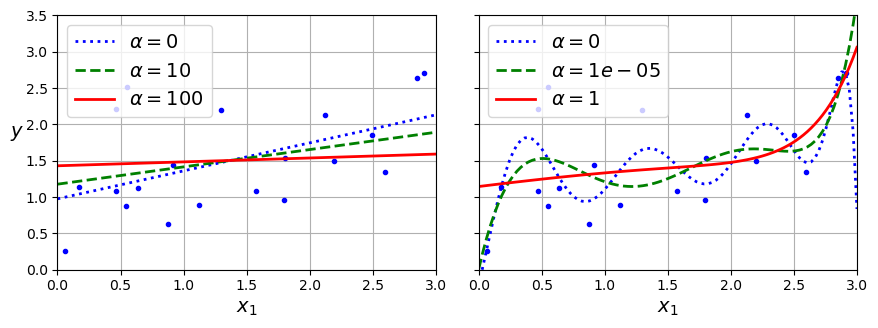

In [37]:
# 추가 코드 - 이 셀은 그림 4-17을 생성하고 저장합니다.

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
save_fig("ridge_regression_plot")
plt.show()

In [38]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # fit()은 1D 타겟을 기대하므로 y.ravel()을 사용합니다.
sgd_reg.predict([[1.5]])

array([1.55302613])

In [39]:
# 추가 코드 - 확률적 평균 GD(solver="sag")를 사용하면 
# 이전과 거의 동일한 솔루션을 얻을 수 있음을 보여줍니다.
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55321535]])

In [40]:
# 추가 코드 - 해석적으로 구한 릿지 회귀의 해를 보여주고
# 아래에서 릿지 모델의 학습된 파라미터와 비교합니다.
alpha = 0.1
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones(m), X]
np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y

array([[0.97898394],
       [0.3828496 ]])

In [41]:
ridge_reg.intercept_, ridge_reg.coef_  # 추가 코드

(array([0.97944909]), array([[0.38251084]]))

## 라쏘 회귀

In [42]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

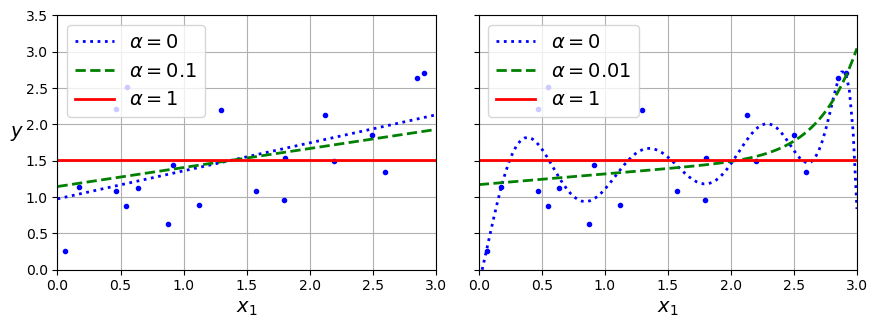

In [43]:
# 추가 코드 - 이 셀은 그림 4-18을 생성하고 저장합니다.
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
save_fig("lasso_regression_plot")
plt.show()

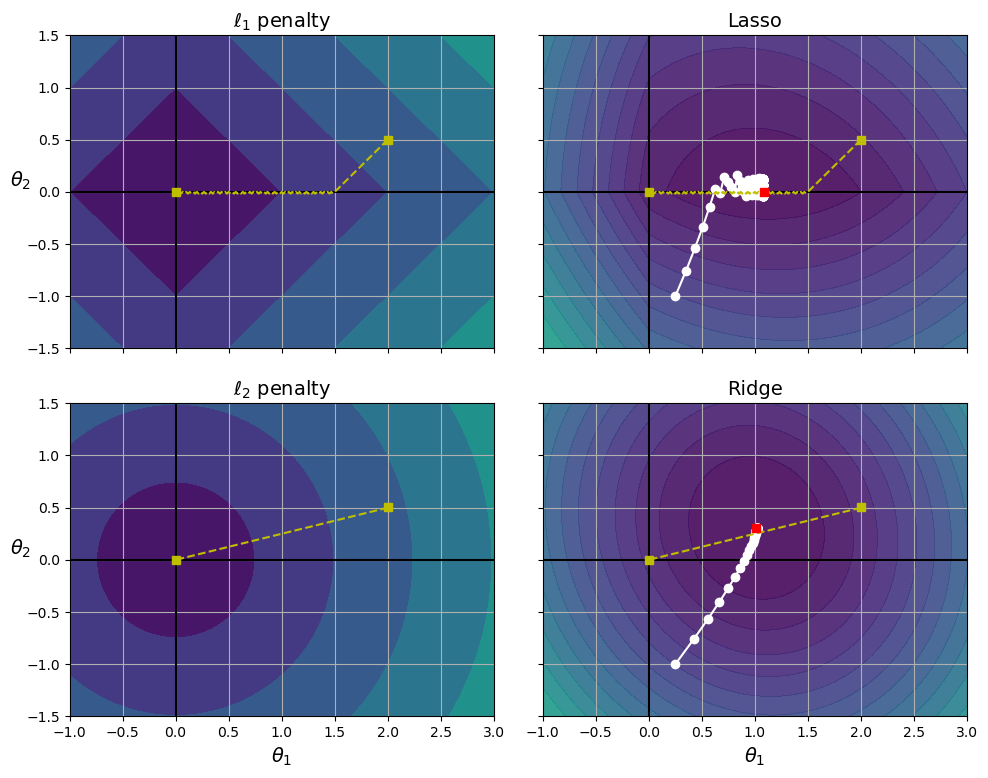

In [44]:
# 추가 코드 - 이 셀은 그림 4-19를 생성하고 저장합니다.

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta=np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1) / 3, l2=np.sign(l2), core=0)
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")

save_fig("lasso_vs_ridge_plot")
plt.show()

## 엘라스틱넷

In [45]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## 조기 종료

앞서 사용한 2차방정식 데이터셋을 다시 사용합니다:

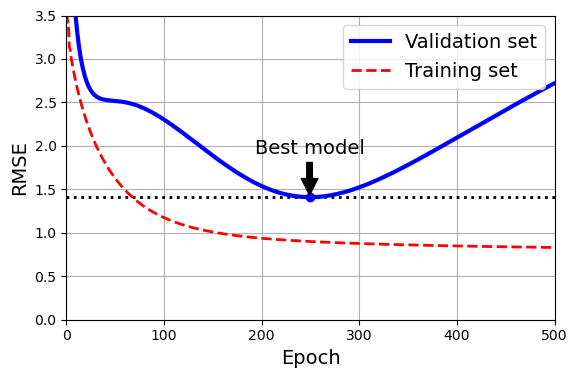

In [46]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 추가 코드 - 이전과 동일한 2차방정식 데이터셋을 생성하고 분할합니다.
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # 추가 코드 - 아래 그림을 위한 것입니다.

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # 추가 코드 - 훈련 오차를 평가하여 그림에 저장합니다.
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

# 추가 코드 - 이 섹션에서는 그림 4-20을 생성하고 저장합니다.
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
save_fig("early_stopping_plot")
plt.show()

# 로지스틱 회귀

## 추정 확률

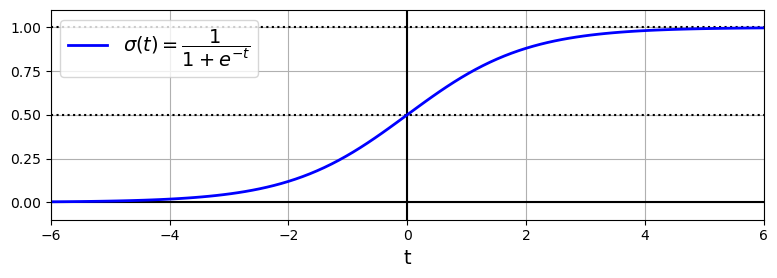

In [47]:
# 추가 코드 - 그림 4-21을 생성하고 저장합니다.

lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()
save_fig("logistic_function_plot")
plt.show()

## 결정 경계

In [48]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [49]:
print(iris.DESCR)  # 추가 코드 - 조금 깁니다.

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [50]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [51]:
iris.target.head(3)  # 샘플이 섞여 있지 않습니다.

0    0
1    0
2    0
Name: target, dtype: int64

In [52]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

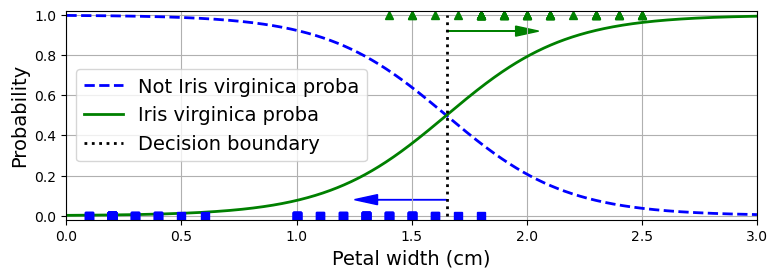

In [54]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # 크기를 바꾸어 열 벡터를 얻습니다.
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))  # 추가 코드
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# 추가 코드 - 이 섹션에서는 그림 4-23을 꾸미고 저장합니다.
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
save_fig("logistic_regression_plot")

plt.show()

In [55]:
decision_boundary

1.6516516516516517

In [56]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

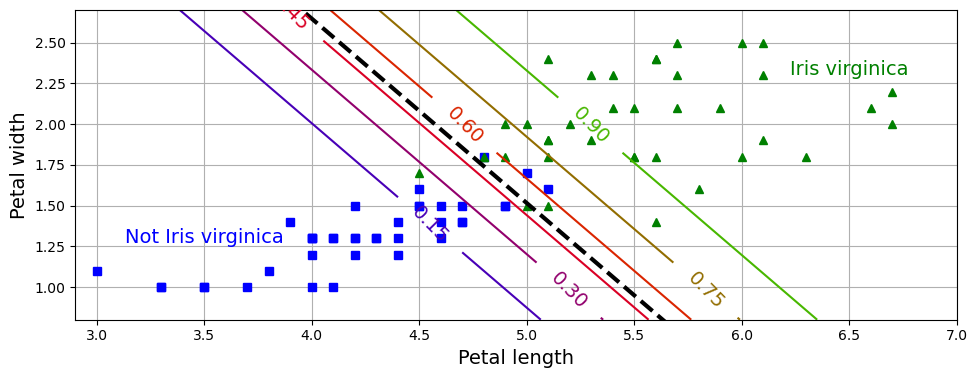

In [57]:
# 추가 코드 - 이 셀은 그림 4-24를 생성하고 저장합니다.

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# 등고선 그래프
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # 그림의 포인트당 하나의 샘플
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# 결정 경계
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
save_fig("logistic_regression_contour_plot")
plt.show()

## 소프트맥스 회귀

In [58]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

In [59]:
softmax_reg.predict([[5, 2]])

array([2])

In [60]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])

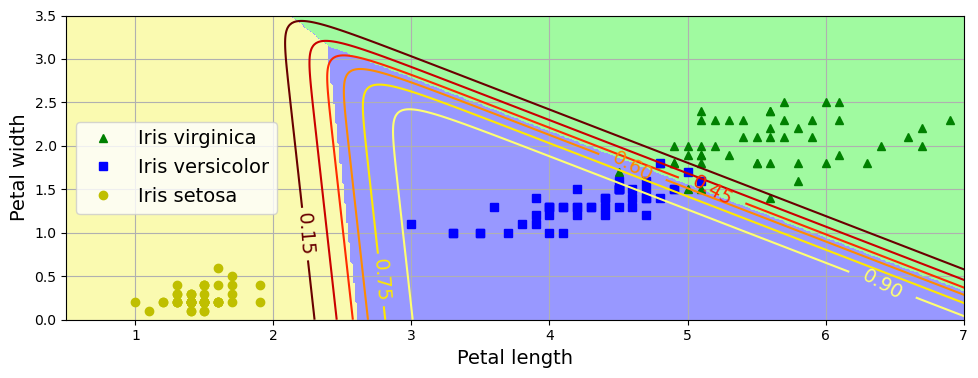

In [61]:
# 추가 코드 - 이 셀은 그림 4-25를 생성하고 저장합니다.

from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
save_fig("softmax_regression_contour_plot")
plt.show()

# 연습문제 해답

## 12. 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀 구현하기
문제: _사이킷런을 사용하지 않고 넘파이만으로 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀를 구현해 보세요. 이를 붓꽃 데이터셋과 같은 분류 작업에 사용해 보세요._

데이터를 로드하는 것부터 시작하겠습니다. 앞서 로드한 붓꽃 데이터셋을 재사용하겠습니다.

In [62]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

모든 샘플에 대해 편향 항을 추가해야 합니다($x_0 = 1$). 이 작업을 수행하는 가장 쉬운 옵션은 사이킷런의 `add_dummy_feature()` 함수를 사용하는 것이지만, 이 연습의 요점은 알고리즘을 수동으로 구현하여 알고리즘을 더 잘 이해하도록 하는 것입니다. 그래서 한 가지 가능한 구현은 다음과 같습니다:

In [63]:
X_with_bias = np.c_[np.ones(len(X)), X]

데이터셋을 훈련 세트, 검증 세트 및 테스트 세트로 분할하는 가장 쉬운 옵션은 사이킷런의 `train_test_split()` 함수를 사용하는 것이지만, 이 역시 수동으로 수행합니다:

In [64]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

현재 타깃은 클래스 인덱스(0, 1 또는 2)이지만, 소프트맥스 회귀 모델을 훈련하려면 타깃 클래스 확률이 필요합니다. 각 샘플은 확률이 1.0인 타깃 클래스를 제외한 모든 클래스에 대해 0.0인 타깃 클래스 확률을 갖습니다(즉, 주어진 샘플에 대한 클래스 확률 벡터는 원-핫 벡터입니다). 클래스 인덱스 벡터를 각 샘플에 대한 원-핫 벡터를 포함하는 행렬로 변환하는 작은 함수를 작성해 보겠습니다. 이 코드를 이해하려면 `np.diag(np.ones(n))`가 주 대각선의 1을 제외한 0으로 가득 찬 n×n 행렬을 생성한다는 사실을 알아야 합니다. 또한 `a`가 넘파이 배열인 경우 `a[[1, 3, 2]]`는 `a[1]`, `a[3]` 및 `a[2]`와 동일한 3개의 행을 가진 배열을 반환합니다(이것이 [고급 넘파이 인덱싱](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing)입니다).

In [65]:
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y]

처음 10개의 샘플에서 이 함수를 테스트해 보겠습니다:

In [66]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [67]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

이제 훈련 세트와 테스트 세트에 대한 타깃 클래스 확률 행렬을 생성해 보겠습니다:

In [68]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

이제 입력의 스케일을 조정해 보겠습니다. 훈련 세트에서 (편향은 제외한) 각 특성의 평균과 표준 편차를 계산한 다음 훈련 세트, 검증 세트 및 테스트 세트에서 각 특성을 중앙에 맞추고 스케일을 조정합니다:

In [69]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

이제 소프트맥스 함수를 구현해 보겠습니다. 다음 방정식으로 정의된다는 것을 기억하세요:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [70]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

훈련을 시작할 준비가 거의 다 되었습니다. 입력과 출력의 수를 정의해 보겠습니다:

In [71]:
n_inputs = X_train.shape[1]  # == 3 (2개의 특성과 편향)
n_outputs = len(np.unique(y_train))  # == 3 (3개의 붓꽃 클래스)

이제 가장 어려운 부분인 훈련입니다! 이론적으로는 간단합니다. 수학 방정식을 파이썬 코드로 변환하기만 하면 됩니다. 하지만 실제로는 상당히 까다로울 수 있습니다. 특히 항의 순서나 인덱스가 혼동되기 쉽습니다. 심지어 제대로 작동하는 것처럼 보이지만 실제로는 정확히 계산되지 않는 코드가 나올 수도 있습니다. 확실하지 않은 경우 방정식의 각 항의 크기를 적어두고 코드의 해당 항이 정확히 일치하는지 확인해야 합니다. 각 항을 독립적으로 평가하고 인쇄하는 것도 도움이 될 수 있습니다. 좋은 소식은 이 모든 것이 사이킷런에 의해 잘 구현되어 있기 때문에 매일 이 작업을 수행할 필요는 없지만, 내부에서 무슨 일이 일어나고 있는지 이해하는 데 도움이 된다는 것입니다.

따라서 우리에게 필요한 방정식은 비용 함수입니다:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

그리고 그레이디언트 방정식입니다:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

$\hat{p}_k^{(i)} = 0$일 때 $\log\left(\hat{p}_k^{(i)}\right)$는 계산할 수 없습니다. 따라서 $\log\left(\hat{p}_k^{(i)}\right)$에 작은 값 $\epsilon$을 더해 `nan` 값을 피합니다.

In [72]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        print(epoch, xentropy_losses.sum(axis=1).mean())
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    Theta = Theta - eta * gradients

0 3.7085808486476917
1000 0.14519367480830644
2000 0.1301309575504088
3000 0.12009639326384539
4000 0.11372961364786884
5000 0.11002459532472425


이게 다입니다! 소프트맥스 모델이 학습되었습니다. 모델 파라미터를 살펴봅시다:

In [73]:
Theta

array([[ 0.41931626,  6.11112089, -5.52429876],
       [-6.53054533, -0.74608616,  8.33137102],
       [-5.28115784,  0.25152675,  6.90680425]])

검증 세트에 대한 예측을 수행하고 정확도 점수를 확인해 보겠습니다:

In [74]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

이 모델은 꽤 괜찮아 보입니다. 연습을 위해 약간의 $\ell_2$ 정규화를 추가해 보겠습니다. 다음 훈련 코드는 위의 코드와 유사하지만 손실에 $\ell_2$ 페널티가 추가되고 그레이디언트가 적절한 추가 항을 가집니다(`Theta`의 첫 번째 원소는 편향에 해당하므로 규제하지 않음). 또한 학습률 `eta`를 높여 보겠습니다.

In [75]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
alpha = 0.01  # 규제 하이퍼파라미터

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
        total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss
        print(epoch, total_loss.round(4))
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
1000 0.3259
2000 0.3259
3000 0.3259
4000 0.3259
5000 0.3259


추가 $\ell_2$ 페널티로 인해 손실이 이전보다 더 커 보이지만 이 모델이 더 나은 성과를 낼 수 있을까요? 알아봅시다:

In [76]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

이 경우 $\ell_2$ 페널티로 인해 테스트 정확도가 변경되지 않았습니다. `alpha`를 미세 튜닝해 볼 수 있을까요?

이제 조기 종료를 추가해 보겠습니다. 이를 위해 모든 반복에서 검증 세트의 손실을 측정하고 오차가 증가하기 시작하면 중지하기만 하면 됩니다.

In [77]:
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100  # 규제 하이퍼파라미터
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "조기 종료!")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
281 0.3256
282 0.3256 조기 종료!


In [78]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

여전히 검증 정확도에는 변화가 없지만, 적어도 조기 중지로 인해 훈련 시간이 조금 단축되었습니다.

이제 전체 데이터셋에 대한 모델의 예측을 그래프로 그려 보겠습니다(모델에 주입하는 모든 특성의 크기를 조정하는 것을 잊지 마세요):

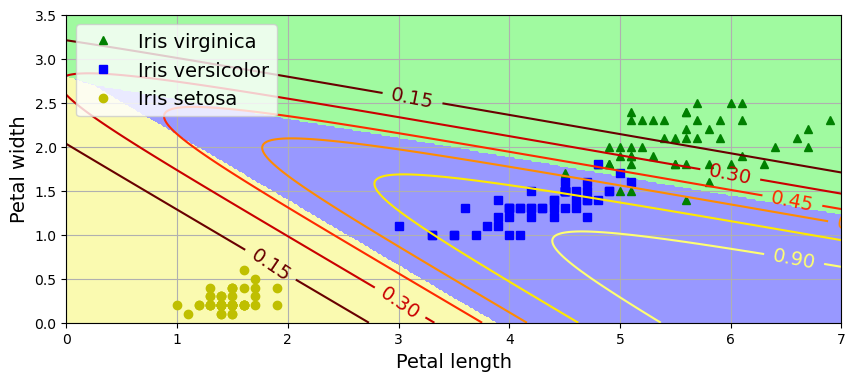

In [79]:
custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

이제 테스트 세트에서 최종 모델의 정확도를 측정해 보겠습니다:

In [80]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9666666666666667

테스트 세트에서 더 나은 성능을 얻었습니다. 이러한 변동성은 데이터셋의 크기가 매우 작기 때문일 수 있습니다. 훈련 세트, 검증 세트 및 테스트 세트의 샘플링 방법에 따라 상당히 다른 결과를 얻을 수 있습니다. 랜덤 시드를 변경하고 코드를 몇 번 다시 실행해 보면 결과가 달라지는 것을 확인할 수 있습니다.